<a href="https://colab.research.google.com/github/SammyGbabs/Time-Series-Forecasting/blob/main/air_quality_forecasting_starter_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beijing Air Quality Forecasting Starter Notebook

In [97]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [98]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
# Load the datasets
train = pd.read_csv('/content/drive/MyDrive/time-series-forecasting/train.csv')
test = pd.read_csv('/content/drive/MyDrive/time-series-forecasting/test.csv')


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [100]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [101]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [102]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)

# **DESCRIPTIVE STATISTICS**

In [103]:
#Statistics of Dataset
train.describe()

,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
count,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,28755.000000
mean,15338.500000,-0.029431,-0.062712,0.013612,0.030542,0.016992,0.011253,0.016193,0.005833,-0.025008,100.793427
std,8855.542765,0.994087,1.015193,1.008991,1.018337,1.087278,1.063811,1.006001,1.001847,0.982122,93.144433
min,1.000000,-2.135153,-2.578070,-2.380821,-0.468688,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,0.000000
25%,7669.750000,-0.888034,-0.938521,-0.822670,-0.441894,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,29.000000
50%,15338.500000,-0.056622,0.045209,-0.043595,-0.352512,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,75.000000
75%,23007.250000,0.913358,0.864984,0.832865,0.005216,-0.069353,-0.137667,1.448138,1.366085,-0.522096,142.000000
max,30676.000000,1.814055,2.340578,2.877939,11.231956,35.439859,25.288745,1.448138,1.366085,1.915355,994.000000


In [104]:
#Identifying Mising Value
train.isnull().sum()

,0
No,0
DEWP,0
TEMP,0
PRES,0
Iws,0
Is,0
Ir,0
cbwd_NW,0
cbwd_SE,0
cbwd_cv,0


In [105]:
#Skewness & Kurtosis
print("Skewness:", train['pm2.5'].skew())
print("Kurtosis:", train['pm2.5'].kurt())

Skewness: 1.8059885615490436
Kurtosis: 5.0973294897056824


In [106]:
#Percentile Analysis (Outliers Detection)
train['pm2.5'].quantile([0.01, 0.25, 0.5, 0.75, 0.99])

,pm2.5
0.01,7.0
0.25,29.0
0.50,75.0
0.75,142.0
0.99,429.0


# **Visiualizations Based on the Dataset**

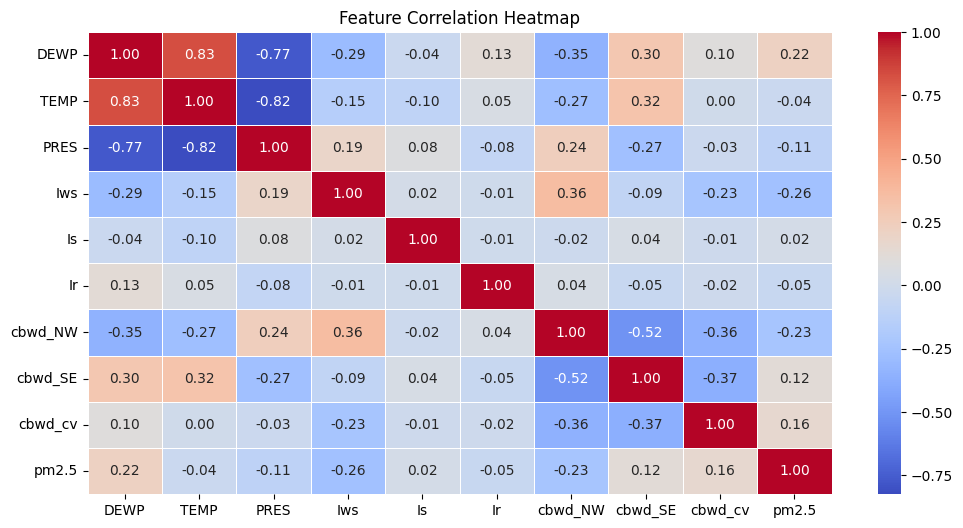

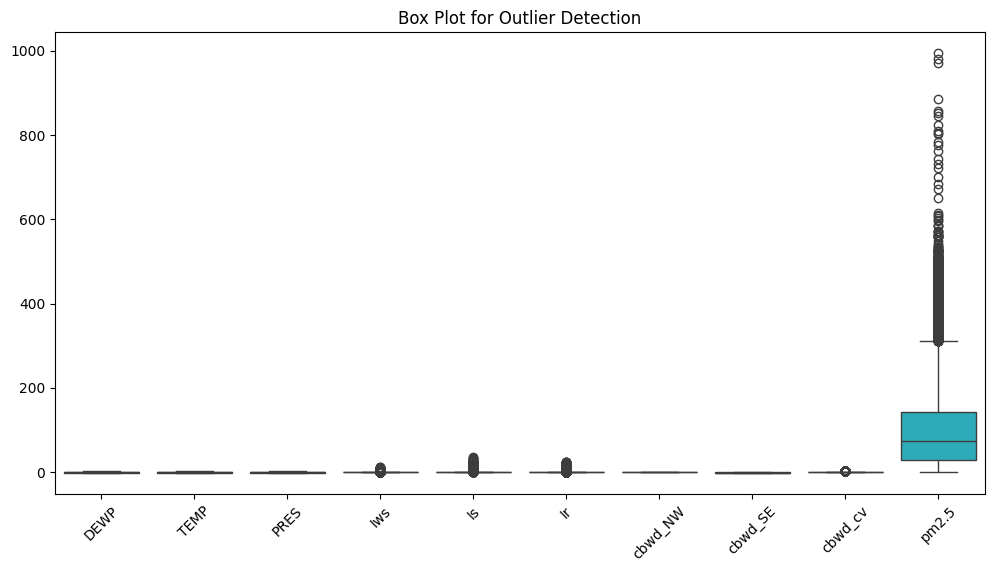

In [107]:
#HeatMap for the Dataset
# Computing the correlation matrix
corr_matrix = train.drop(columns=['No']).corr()  # Exclude non-numeric columns

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Plot boxplots for all numerical columns
plt.figure(figsize=(12, 6))
sns.boxplot(train.drop(columns=['No']))
plt.xticks(rotation=45)
plt.title("Box Plot for Outlier Detection")
plt.show()


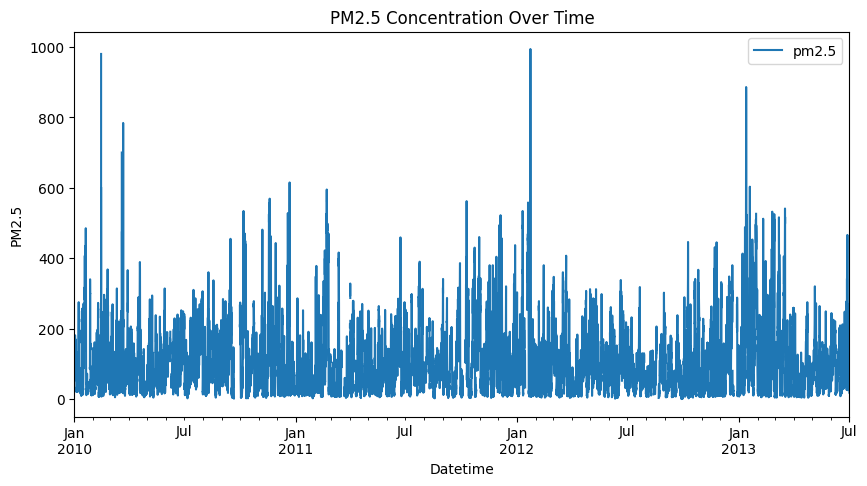

In [108]:
# Line Plot PM2.5 over time
train.plot(y='pm2.5', figsize=(10,5), title="PM2.5 Concentration Over Time")
plt.xlabel("Datetime")
plt.ylabel("PM2.5")
plt.show()

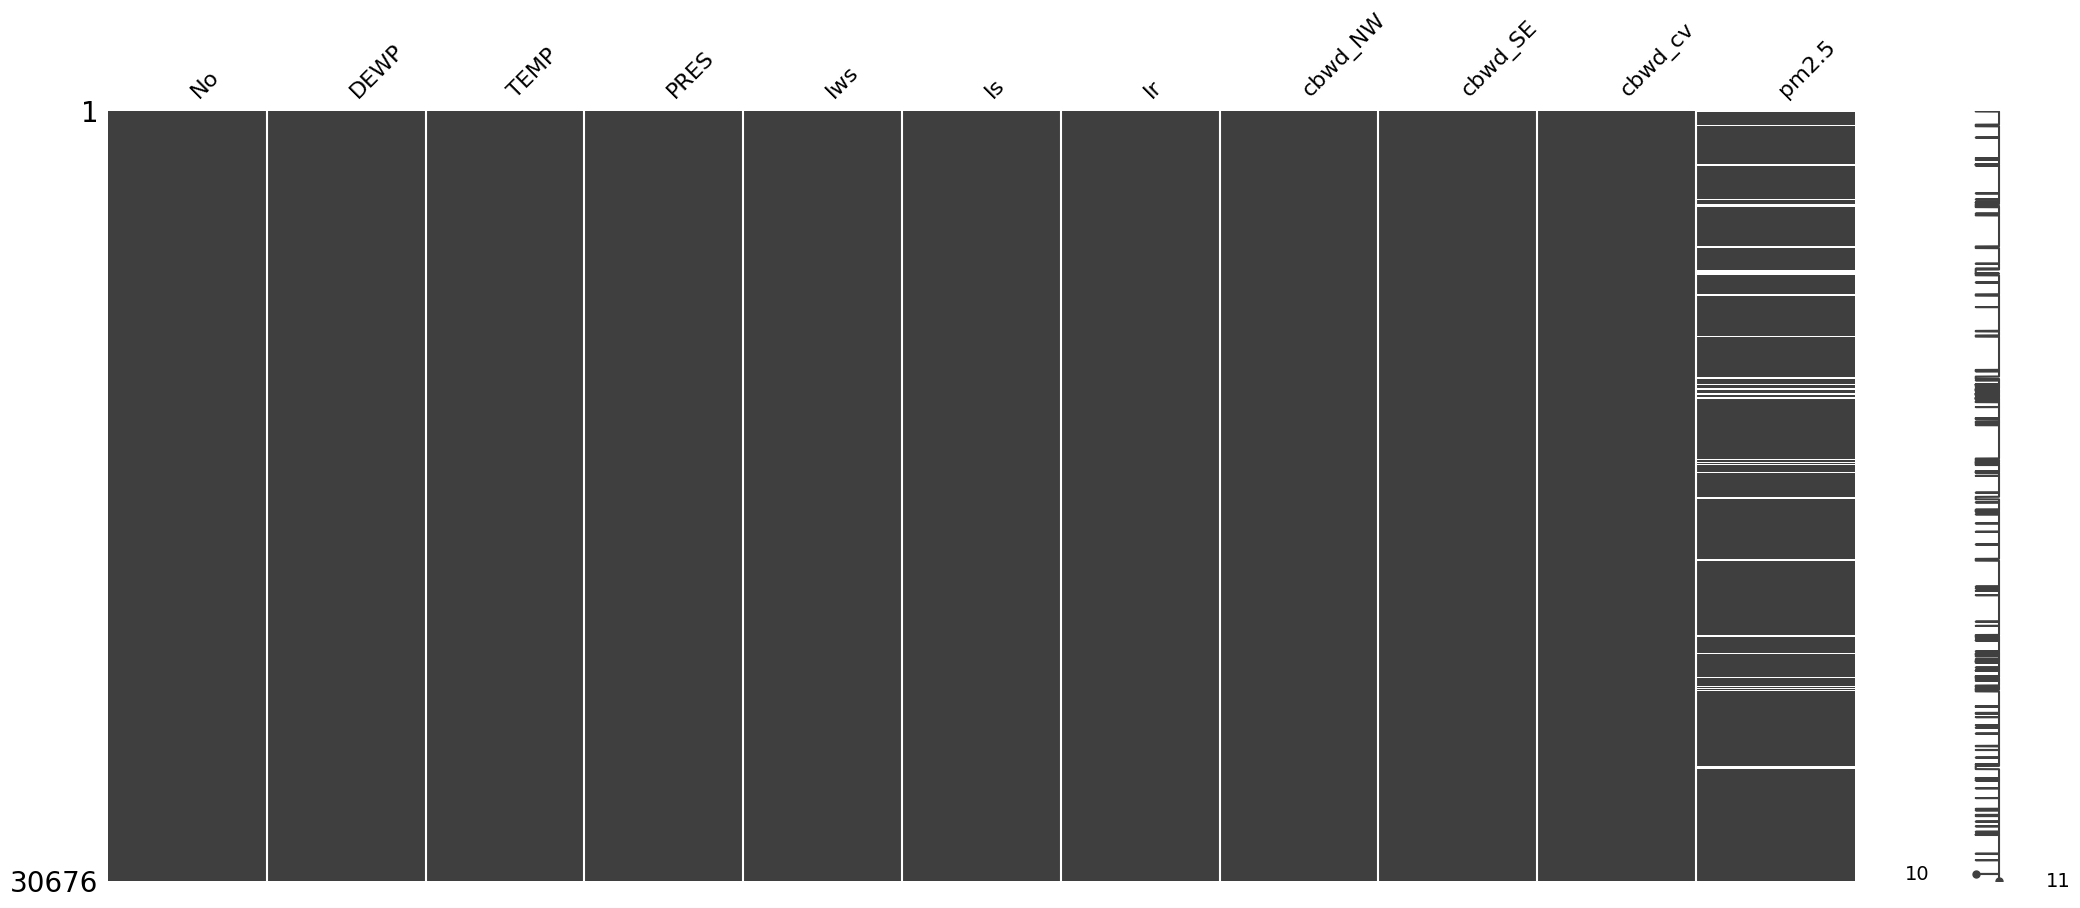

In [109]:
#Missing Value Heatmap
msno.matrix(train)
plt.show()

# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

<ipython-input-110-e09886546f8c>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train['pm2.5'] = train['pm2.5'].interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


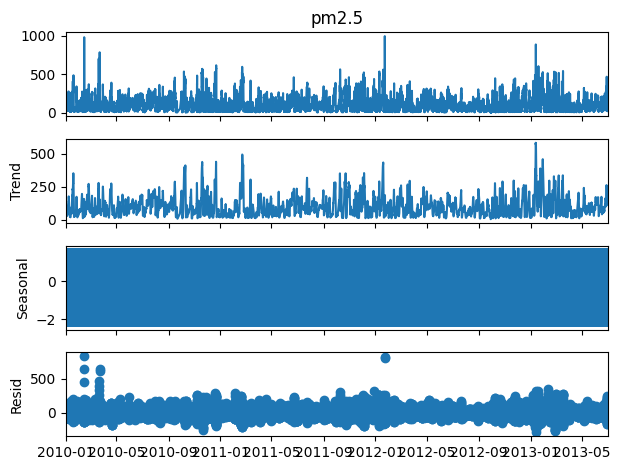

In [110]:
# Ensure 'pm2.5' column is numeric
train['pm2.5'] = pd.to_numeric(train['pm2.5'], errors='coerce')

# Interpolate missing values and then forward-fill any remaining NaNs
train['pm2.5'] = train['pm2.5'].interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')

# Perform seasonal decomposition after ensuring no missing values
result = seasonal_decompose(train['pm2.5'], model='additive', period=30)

# Plot decomposition
result.plot()
plt.show()

# **TEMPORAL FEATURE ENGINEERING**

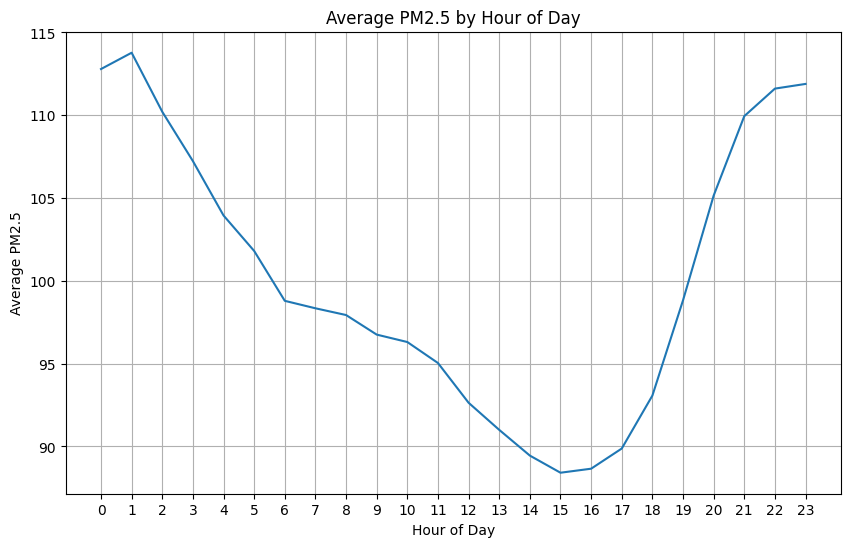

In [111]:
# Extract components from the datetime index
for df in [train, test]:
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['weekday'] = df.index.weekday
    df['season'] = (df.index.month % 12 + 3) // 3

plt.figure(figsize=(10, 6))
hourly_pm25 = train.groupby('hour')['pm2.5'].mean()
plt.plot(hourly_pm25)
plt.xlabel('Hour of Day')
plt.ylabel('Average PM2.5')
plt.title('Average PM2.5 by Hour of Day')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

# **NORMALIZATION**

In [112]:
# Separate features and target
X_train = train.drop(['pm2.5', 'No'], axis=1, errors='ignore')
y_train = train['pm2.5']

In [113]:
# Standardize features
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)

# Standardize target
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [114]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE',
       'cbwd_cv', 'pm2.5', 'hour', 'day', 'month', 'weekday', 'season'],
      dtype='object')

In [115]:
# --- FUNCTION TO CREATE TIME SERIES SEQUENCES ---
def create_sequences(X, y, timesteps):
    Xs, ys = [], []
    for i in range(len(X) - timesteps):
        # Take 'timesteps' number of past observations (features)
        Xs.append(X[i:(i + timesteps)])
        # The target is the value at the next timestep
        ys.append(y[i + timesteps])
    return np.array(Xs), np.array(ys)

# Define the number of timesteps to look back
timesteps = 24

In [116]:
# Create sequences from the *full* scaled training data first
X_train_sequences_full, y_train_sequences_full = create_sequences(X_train_scaled, y_train_scaled, timesteps)

# Now, split the *sequenced* data into training and validation sets
X_train_split, X_val_sequences, y_train_split, y_val_sequences = train_test_split(
    X_train_sequences_full, y_train_sequences_full, test_size=0.2, random_state=42, shuffle=False
)

print(f"Shape of X_train_split: {X_train_split.shape}")
print(f"Shape of y_train_split: {y_train_split.shape}")
print(f"Shape of X_val_sequences: {X_val_sequences.shape}")
print(f"Shape of y_val_sequences: {y_val_sequences.shape}")

Shape of X_train_split: (24521, 24, 14)
Shape of y_train_split: (24521, 1)
Shape of X_val_sequences: (6131, 24, 14)
Shape of y_val_sequences: (6131, 1)


# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [117]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

model = Sequential([
    #Bidirectional(LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train_sequences.shape[1], X_train_sequences.shape[2]))),
    #Dropout(0.2),
    LSTM(64, activation='tanh', return_sequences=False, input_shape=(X_train_split.shape[1], X_train_split.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile with RMSE as a monitored metric
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

# Display the model architecture
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,337 (87.25 KB)

 Trainable params: 22,337 (87.25 KB)

 Non-trainable params: 0 (0.00 B)

In [118]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Callbacks for early stopping and learning rate reduction
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    # Add ModelCheckpoint to save the best model weights
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
]

In [119]:
# Train the model
history = model.fit(
    X_train_split, y_train_split,
    validation_data=(X_val_sequences, y_val_sequences),
    epochs=200,
    batch_size=64,
    callbacks=callbacks
)

Epoch 1/200
382/384 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5532 - rmse: 0.7410
Epoch 1: val_loss improved from inf to 0.83029, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.5524 - rmse: 0.7404 - val_loss: 0.8303 - val_rmse: 0.9112 - learning_rate: 0.0010
Epoch 2/200
383/384 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3316 - rmse: 0.5758
Epoch 2: val_loss did not improve from 0.83029
384/384 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.3316 - rmse: 0.5757 - val_loss: 0.8652 - val_rmse: 0.9302 - learning_rate: 0.0010
Epoch 3/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2712 - rmse: 0.5205
Epoch 3: val_loss improved from 0.83029 to 0.82508, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.2711 - rmse: 0.5205 - val_loss: 0.8251 - val_rmse: 0.9083 - learning_rate: 0.0010
Epoch 4/200
381/384 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2258 - rmse: 0.4751
Epoch 4: val_loss did not improve from 0.82508
384/384 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.2257 - rmse: 0.4750 - val_loss: 0.8473 - val_rmse: 0.9205 - learning_rate: 0.0010
Epoch 5/200
383/384 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1906 - rmse: 0.4365
Epoch 5: val_loss did not improve from 0.82508
384/384 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.1906 - rmse: 0.4365 - val_loss: 0.8406 - val_rmse: 0.9168 - learning_rate: 0.0010
Epoch 6/200
382/384 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1751 - rmse: 0.4184
Epoch 6: val_loss did not improve from 0.82508
384/384 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.1751 - rmse: 0.4184 - val_loss: 0.8690 - val_rmse: 0.9322 - learning_rate: 0.0010
Epoch 7/200
381/384 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1540 -

384/384 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.1539 - rmse: 0.3919 - val_loss: 0.8158 - val_rmse: 0.9032 - learning_rate: 0.0010
Epoch 8/200
383/384 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1339 - rmse: 0.3659
Epoch 8: val_loss did not improve from 0.81580
384/384 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.1339 - rmse: 0.3659 - val_loss: 0.8439 - val_rmse: 0.9186 - learning_rate: 0.0010
Epoch 9/200
383/384 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1199 - rmse: 0.3460
Epoch 9: val_loss did not improve from 0.81580
384/384 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.1199 - rmse: 0.3461 - val_loss: 0.8955 - val_rmse: 0.9463 - learning_rate: 0.0010
Epoch 10/200
381/384 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1189 - rmse: 0.3447
Epoch 10: val_loss did not improve from 0.81580
384/384 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.1189 - rmse: 0.3447 - val_loss: 0.8907 - val_rmse: 0.9438 - learning_rate: 0.0010
Epoch 11/200
383/384 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.103

958/958 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


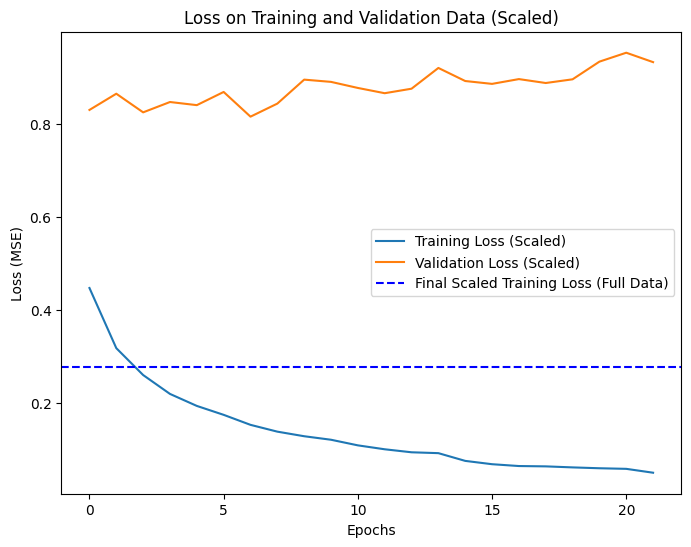

Final Training Loss (MSE on Original Scale): 2319.572617490788
Final Training Loss (MSE on Scaled Data): 0.2772537393327847


In [120]:
# Recreate sequences for the entire training data for prediction
X_train_sequences_full, y_train_sequences_full = create_sequences(X_train_scaled, y_train_scaled, timesteps)


# Now predict using the sequences
train_predictions = model.predict(X_train_sequences_full)

# Inverse transform predictions and actuals for loss calculation on original scale
train_predictions_original_scale = scaler_y.inverse_transform(train_predictions)
y_train_original_scale = scaler_y.inverse_transform(y_train_sequences_full)


# Calculate MSE loss on the original scale
train_loss = np.mean((y_train_original_scale.flatten() - train_predictions_original_scale.flatten())**2)


# Calculate scaled training loss for plotting alongside validation loss
train_loss_scaled = np.mean((y_train_sequences_full - train_predictions)**2)


# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss (Scaled)')
plt.plot(history.history['val_loss'], label='Validation Loss (Scaled)')
# The axhline should represent the final scaled training loss on the sequences used for training the model (X_train_split, y_train_split)
plt.axhline(y=train_loss_scaled, color='blue', linestyle='--', label='Final Scaled Training Loss (Full Data)')
plt.title('Loss on Training and Validation Data (Scaled)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# Print the loss calculated on the original scale
print(f"Final Training Loss (MSE on Original Scale): {train_loss}")
print(f"Final Training Loss (MSE on Scaled Data): {train_loss_scaled}")

In [121]:
# Corrected variable name from X_train_features to X_train
all_data_features = pd.concat([X_train, test.drop(['No'], axis=1, errors='ignore')], axis=0) # Include test features

# Scale all data features using the scaler fitted on training data
all_data_scaled = scaler_x.transform(all_data_features)

# The sequences for the test set will start after the training set's target values.
X_all_sequences, y_all_sequences_dummy = create_sequences(all_data_scaled, np.zeros(len(all_data_scaled)), timesteps) # y is dummy here

# To predict index `len(train)`, the sequence index `i` must be `len(train) - timesteps`.

start_index_for_test_sequences = len(train) - timesteps
X_test_sequences = X_all_sequences[start_index_for_test_sequences:]

print(f"Shape of X_test_sequences: {X_test_sequences.shape}")

# Make predictions on the test set using trained model
predictions = model.predict(X_test_sequences)

# Convert back to original scale
predictions = scaler_y.inverse_transform(predictions)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# The maximum value might need adjustment based on data distribution or domain knowledge.
predictions = np.clip(predictions, 0, predictions.max())

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# The index of the test set dataframe matches the row ID.
submission = pd.DataFrame({
    # Use the actual index of the test DataFrame for 'row ID'
    'row ID': test.index.strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Define the directory path where you want to save the file
save_directory = '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting'

# Create the directory if it does not exist
import os
os.makedirs(save_directory, exist_ok=True)

# Define the full file path
file_path = os.path.join(save_directory, 'sample_submission_main.csv')

# Save the file in CSV format for submission on Kaggle
submission.to_csv(file_path, index=False)

Shape of X_test_sequences: (13148, 24, 14)
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
